# Import Dependecies


In [1]:
#!pip install opencv-python matplotlib

In [2]:
import cv2
import os
import random
import random 
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer , Conv2D , Dense , MaxPooling2D , Input, Flatten
import tensorflow as tf

# Set GPU Growth

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Folder Structure

In [6]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
# Make the directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

# Collect positives and anchor

Data url : http://vis-www.cs.umass.edu/lfw/

# Unzip data

In [8]:
# !tar -xf lfw.tgz

In [9]:
# Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

# Collect positive and anchor classes

In [10]:
# Import uuid library to generate unique image names
import uuid

In [11]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\b3b33738-9221-11ec-8b31-f4b5202c69a7.jpg'

In [12]:
#Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [13]:
# plt.imshow(frame)

# Load and Preprocess Images

## Get Image Directories

In [14]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [15]:
dir_test = anchor.as_numpy_iterator()

In [16]:
print(dir_test.next())

b'data\\anchor\\9b7cf019-19e6-11ec-b155-f4b5202c69a7.jpg'


## Preprocessing - Scale and Resize

In [17]:
def preprocess(file_path):
    #READ Image from file path as byte
    byte_img = tf.io.read_file(file_path)
    #Load the image
    img = tf.io.decode_jpeg(byte_img)
    #Preprocessing 100 pixels * 100 pixels 
    img = tf.image.resize(img,(100,100))
    img = img/255.0
    return img

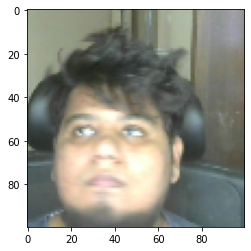

In [18]:
img = preprocess('data\\anchor\\96816bbe-19e6-11ec-a50f-f4b5202c69a7.jpg')
plt.imshow(img)

In [19]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [20]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [21]:
samples = data.as_numpy_iterator()
example = samples.next()

In [22]:
example

(b'data\\anchor\\771490ad-19e6-11ec-bc19-f4b5202c69a7.jpg',
 b'data\\positive\\37a246ef-19e6-11ec-aa66-f4b5202c69a7.jpg',
 1.0)

## Build Train and Test Partition

In [23]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [24]:
res =preprocess_twin(*example)

In [25]:
res[2]

1.0

# Building Dataloader pipeline

In [26]:
#Building Dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

# Training partition

In [27]:
train_data= data.take(round(len(data)*7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [28]:
train_data

<PrefetchDataset shapes: ((None, 100, 100, None), (None, 100, 100, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

In [29]:
train_samples = train_data.as_numpy_iterator()

In [30]:
train_sample = train_samples.next()

In [31]:
train_sample = train_samples.next()

In [32]:
len(train_sample[0])

16

# Testing partition

In [33]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [34]:
test_data

<PrefetchDataset shapes: ((None, 100, 100, None), (None, 100, 100, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

In [35]:
test_samples = test_data.as_numpy_iterator()

In [36]:
test_sample = test_samples.next()

In [37]:
len(test_sample[0])

16

# Building Embedding layer

In [38]:
def make_embedding():
    inp = Input(shape=(100,100,3),name='input_image')
    
    #First Block
    c1 = Conv2D(64,(10,10),activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    
    #Second Block
    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    
    
    #Third Block
    c3 = Conv2D(128,(4,4),activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2),padding='same')(c3)
    
    #Fourth Block
    c4 = Conv2D(256,(4,4),activation='relu')(m3)
    f1= Flatten()(c4)
    d1 = Dense(4096,activation='sigmoid')(f1)
    
    
    
    
    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [39]:
embedding = make_embedding()

In [40]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

# Siamese L1 Distance Class creation

In [41]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    # What to do actually is done where (Similarity Check)
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [42]:
def make_siamese_model():
    
    #Handle inputs
    
    #Anchor image in network
    input_image = Input(name='input_img',shape=(100,100,3))
    
    
    #Validation image in network
    validation_image = Input(name='validation_img',shape=(100,100,3))
    
    #Combine components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    
    #Classification Layer
    classifier = Dense(1,activation='sigmoid')(distances)
    
    return Model(inputs=[input_image,validation_image],outputs = classifier,name='SiameseNetwork')

In [43]:
siamese_model = make_siamese_model()

In [44]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

# Training

In [45]:
#Setup loss optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [46]:
#Adam optimizer
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [47]:
#Establish Checkpoints

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [48]:
#Train Step function
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss
    

In [49]:
#Build training loop
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)


In [50]:
EPOCHS = 50

In [51]:
#Don't use it now
#train(train_data, EPOCHS)

In [52]:
from tensorflow.keras.metrics import Precision,Recall

In [53]:
test_input , test_val , y_true = test_data.as_numpy_iterator().next()

In [54]:
test_var = test_data.as_numpy_iterator().next()

# Make predictions

In [55]:
#Make predictions
'''y_hat = siamese_model.predict([test_input,test_val])
y_hat'''

'y_hat = siamese_model.predict([test_input,test_val])\ny_hat'

In [56]:
'''[1 if prediction > 0.5 else 0 for prediction in y_hat]'''

'[1 if prediction > 0.5 else 0 for prediction in y_hat]'

In [57]:
#y_true

In [58]:
'''
m = Recall()
m.update_state(y_true,y_hat)
m.result().numpy()
'''

'\nm = Recall()\nm.update_state(y_true,y_hat)\nm.result().numpy()\n'

In [59]:
'''m = Precision()
m.update_state(y_true,y_hat)
m.result().numpy()
'''

'm = Precision()\nm.update_state(y_true,y_hat)\nm.result().numpy()\n'

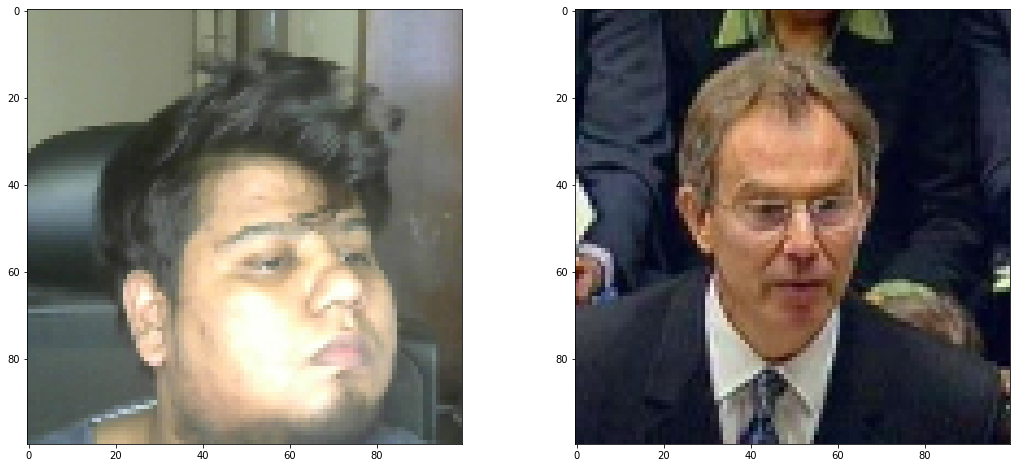

In [60]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[8])
plt.show()

In [61]:
# Save weights 
#siamese_model.save('siamese_model.h5')

In [62]:
# Reload model
model = tf.keras.models.load_model('siamese_model.h5',custom_objects={'L1Dist':L1Dist,'BinaryCrissentropy':tf.losses.BinaryCrossentropy})

In [63]:
def verify(model,detection_threshold,verification_threshold):
    
    results= []    
    
    for image in os.listdir(os.path.join('application_data','verification_images')):
        #print(image)
        input_img = preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        #print(input_img)
        validation_img = preprocess(os.path.join('application_data','verification_images',image))
        #print(validation_img)
        
        # Make predictions
        result = model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)
    detection = np.sum(np.array(results)>detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data','verification_images')))
    verified = verification > verification_threshold
    return results , verified

In [74]:
#Establish connection to webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret , frame = cap.read()
    frame = frame[120:120+250,200:200+250,:]
    cv2.imshow('Verification',frame)
    #Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #Save input image to image folder in application
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'),frame)
        results , verified = verify(model,0.9,0.7)
        print(verified)
        
    
    
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
    
#Release webcam
cap.release()
cv2.destroyAllWindows()

True
True
True
False
True
False
False
True
